### Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from pprint import pprint

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
df = pd.read_pickle('/content/drive/MyDrive/Capstone_electriccar/pre-processed.pkl')

In [3]:
df.shape

(36308, 7)

In [4]:
df = df.drop(['tidy_tweet','tidy_tweet_tokens','no_stop_joined','Hashtag','Location'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36308 entries, 0 to 36307
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tweet Text      36308 non-null  object
 1   tokens_no_stop  36308 non-null  object
dtypes: object(2)
memory usage: 567.4+ KB


In [6]:
df.head()

,Tweet Text,tokens_no_stop
0,Join our next webinar on 'Alternative Fuel Typ...,"[join, next, webinar, alternative, fuel, type,..."
1,RT @events_wisdom: How the #hydrogen productio...,"[production, techniques, impacting, hydrogen, ..."
2,How the #hydrogen production techniques are im...,"[production, techniques, impacting, hydrogen, ..."
3,RT @events_wisdom: Join our upcoming event to ...,"[join, upcoming, event, hear, robert, paulnste..."
4,RT @HELLENICSHIP: Stena Line achieves another ...,"[stena, line, achieves, another, world, first,..."


### Pre-Processing

#### Remove Links

In [7]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [8]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['Tweet Text'])

In [9]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"twitter.com\S+", "", tweet)
    return tweet_no_link

In [10]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text_p'])

### Remove twitter handles

In [11]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [12]:
df['tweet_text_p'] = np.vectorize(remove_users)(df['tweet_text_p'], "@ [\w]*", "@[\w]*")

### Remove Hashtag

In [13]:
# We decided to keep hashtags because they add value to the sentiment.
# Example df.tweet_text[20]
def remove_hashtags(tweet, pattern1):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [14]:
df['tweet_text_p'] = np.vectorize(remove_hashtags)(df['tweet_text_p'], "#")

### remove collection of words (electric)

In [15]:
# It adds to the neutrality of the tweet as the compound score is the sum of all words sentiment score. 
# Example df.tweet_text[43]
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [16]:
df['tweet_text_p'] = np.vectorize(remove_word)(df['tweet_text_p'], "electric", "Tesla")

### Remove Duplicates

In [17]:
df.drop_duplicates(subset=['tweet_text_p'], keep='first', inplace=True)

In [18]:
df = df[~df.tweet_text_p.str.contains("Retweeted")]

In [19]:
df.shape

(33390, 3)

### Applying VADER Sentiment Analyzer

In [20]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [21]:
negative = []
neutral = []
positive = []
compound = []

In [22]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['tweet_text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [23]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [24]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [25]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [26]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

### Number of tweets by sentiment

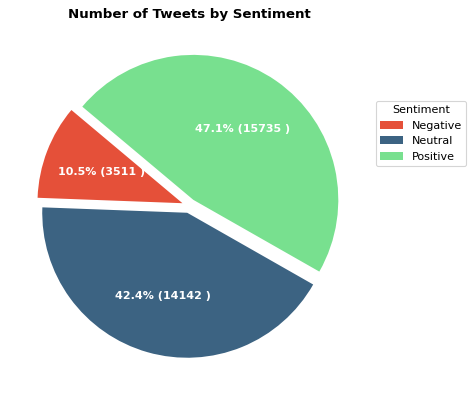

In [27]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment", fontsize=12, fontweight="bold")
plt.show()

### Histogram

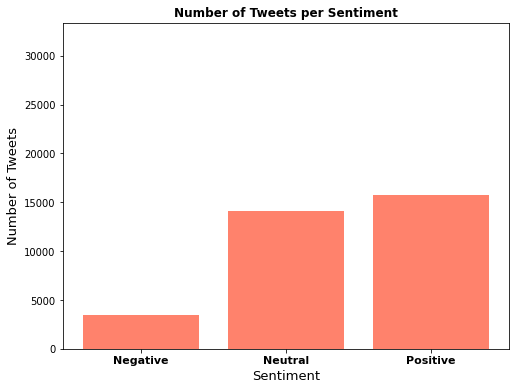

In [28]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'tomato')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['Tweet Text']))
plt.show()

### Density Plot of Overall compound score

In [29]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

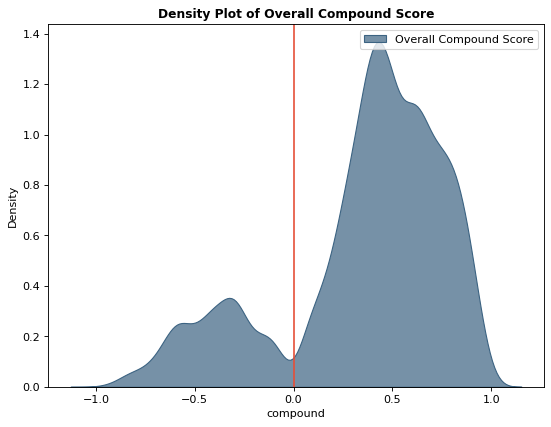

In [30]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11, fontweight='bold')
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

### Word Cloud of Positive and Negative Tweets

### Lemmatization

In [31]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [32]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [33]:
# Do lemmatization keeping only noun, adj, vb, adv
df['lemmatized'] = lemmatization(df['tokens_no_stop'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [34]:
df.drop(['tokens_no_stop'], axis=1, inplace=True)

In [35]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [36]:
df_pos.head()

,Tweet Text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Join our next webinar on 'Alternative Fuel Typ...,Join our next webinar on 'Alternative Fuel Typ...,0.0,0.879,0.121,0.296,1,"[join, next, webinar, alternative, fuel, type,..."
1,RT @events_wisdom: How the #hydrogen productio...,RT : How the hydrogen production techniques ar...,0.0,0.891,0.109,0.296,1,"[production, technique, impact, hydrogen, econ..."
2,How the #hydrogen production techniques are im...,How the hydrogen production techniques are imp...,0.0,0.885,0.115,0.296,1,"[production, technique, impact, hydrogen, econ..."
3,RT @events_wisdom: Join our upcoming event to ...,RT : Join our upcoming event to hear from Robe...,0.0,0.885,0.115,0.296,1,"[join, upcoming, event, hear]"
6,Join our upcoming event to hear from Robert Pa...,Join our upcoming event to hear from Robert Pa...,0.0,0.872,0.128,0.296,1,"[join, upcoming, event, hear]"


### WordCloud 

In [37]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [38]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

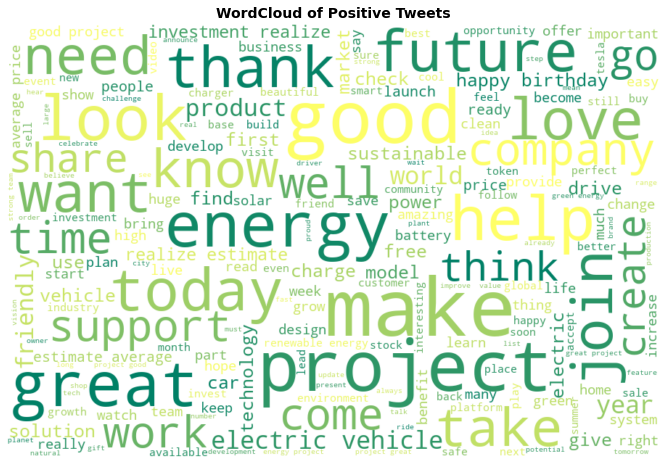

In [39]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=200,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

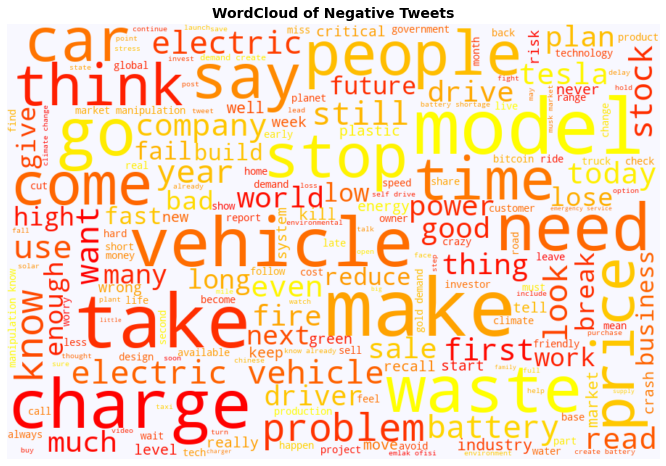

In [40]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Compound Score Distribution 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


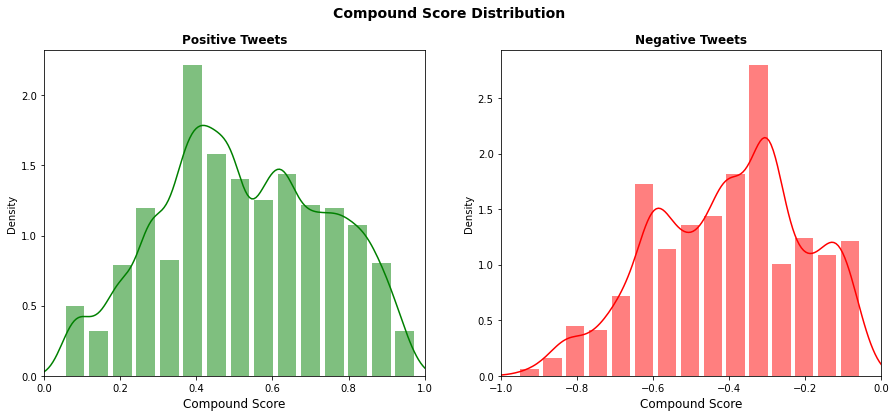

In [41]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=15, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive Tweets',fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

In [42]:
x1.describe()

count    15736.000000
mean         0.523374
std          0.218053
min          0.050000
25%          0.361200
50%          0.510600
75%          0.698850
max          0.979000
Name: compound, dtype: float64

In [43]:
x2.describe()

count    3511.000000
mean       -0.402858
std         0.196550
min        -0.954500
25%        -0.557400
50%        -0.388500
75%        -0.273200
max        -0.051600
Name: compound, dtype: float64

### Box Plot

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


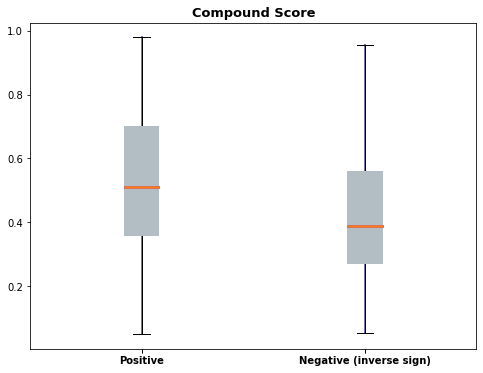

In [44]:
data_to_plot = [x1,(x2)*-1]
# Box-plot
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, patch_artist=True)
for box in bp['boxes']:
    # change outline color
    box.set( color='#b2bec3', linewidth=2)
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
for median in bp['medians']:
    median.set(color='#e17055', linewidth=3)
plt.boxplot(data_to_plot)
plt.title('Compound Score', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Positive', 'Negative (inverse sign)'], fontweight='bold')
plt.show()

### 10 Most Positive and Negative Tweets

In [45]:
# 10 Most positive Tweets
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
df_pos.head(10)

,Tweet Text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,RT @Jamalediputra93: A great project that is s...,RT : A great project that is strong and a good...,0.0,0.311,0.689,0.9790,1,"[great, project, strong, good, know, team, def..."
1,A great project that is strong and a good know...,A great project that is strong and a good know...,0.0,0.273,0.727,0.9790,1,"[great, project, strong, good, know, team, def..."
2,"Happy birthday Elon!!! Great man, great fathe...","Happy birthday Elon!!! Great man, great fathe...",0.0,0.315,0.685,0.9773,1,"[happy, birthday, great, great, business, grea..."
3,This is an exciting initiative with great pros...,This is an exciting initiative with great pros...,0.0,0.265,0.735,0.9750,1,"[exciting, great, prospect, strong, positive, ..."
4,RT @NAHIDNK353: This is an exciting initiative...,RT : This is an exciting initiative with great...,0.0,0.324,0.676,0.9750,1,"[exciting, great, prospect, strong, positive, ..."
5,RT @bountyrasel: The Project will be a huge su...,RT : The Project will be a huge success thanks...,0.0,0.372,0.628,0.9738,1,"[project, huge, success, thank, strong, dedica..."
6,HAPPY BIRTHDAY TO YOU\nHAPPY BIRTHDAY TO YOU\n...,HAPPY BIRTHDAY TO YOU\nHAPPY BIRTHDAY TO YOU\n...,0.0,0.413,0.587,0.9731,1,"[happy, birthday, happy, birthday, happy, birt..."
7,RT @maria_ushyvets: HAPPY BIRTHDAY TO YOU\nHAP...,RT : HAPPY BIRTHDAY TO YOU\nHAPPY BIRTHDAY TO ...,0.0,0.428,0.572,0.9731,1,"[happy, birthday, happy, birthday, happy, birt..."
8,A great project that is strong and a good know...,A great project that is strong and a good know...,0.0,0.300,0.700,0.9729,1,"[great, project, strong, good, know, team, def..."
9,This project includes a number of best things:...,This project includes a number of best things:...,0.0,0.351,0.649,0.9726,1,"[project, include, number, good, thing, great,..."


In [47]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True).head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tweet Text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,The worst point of Malaysia. The worst governm...,The worst point of Malaysia. The worst governm...,0.599,0.401,0.0,-0.9545,-1,"[bad, point, bad, government, bad, bad]"
1,RT @rafhanrafidzi: The worst point of Malaysia...,RT : The worst point of Malaysia. The worst go...,0.577,0.423,0.0,-0.9545,-1,"[bad, point, bad, government, bad, bad]"
2,RT @shrikant_sh8y: I hate @elonmusk . Built AI...,RT : I hate . Built AI that killed people. Bu...,0.512,0.488,0.0,-0.9403,-1,"[hate, build, kill, people, build, rocket, use..."
3,I hate @elonmusk . Built AI that killed people...,I hate . Built AI that killed people. Built r...,0.531,0.469,0.0,-0.9403,-1,"[hate, build, kill, people, build, rocket, use..."
4,@carterbradleyj @weedepot i hate smelling othe...,i hate smelling other peoples shit. fuck tha...,0.589,0.411,0.0,-0.9171,-1,"[hate, smell, people, shit, fuck, herbal, ince..."
5,In Tschechien bahnt sich großes an. #CEZ die F...,In Tschechien bahnt sich großes an. CEZ die Fi...,0.381,0.619,0.0,-0.9136,-1,[]
6,Bin gespannt auf die Konditionen und die Zahlu...,Bin gespannt auf die Konditionen und die Zahlu...,0.438,0.562,0.0,-0.9136,-1,[]
7,RT @sascha_p: Glueckwunsch an die Kolleg:innen...,RT : Glueckwunsch an die Kolleg:innen der zum...,0.438,0.562,0.0,-0.9136,-1,[auch]
8,A whole ass tornado was forming and then went ...,A whole ass tornado was forming and then went ...,0.506,0.494,0.0,-0.9052,-1,"[whole, tornado, forming, go, away, fuck, shit..."
9,I HATE #Tesla!!!!! Dont ever buy #Solar Panels...,I HATE !!!!! Dont ever buy Solar Panels from t...,0.412,0.588,0.0,-0.9042,-1,"[hate, ever, panel, company, regret, stress, a..."


### Trying and Testing on specific Tweets

In [48]:
df.head(5)

,Tweet Text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Join our next webinar on 'Alternative Fuel Typ...,Join our next webinar on 'Alternative Fuel Typ...,0.0,0.879,0.121,0.296,1,"[join, next, webinar, alternative, fuel, type,..."
1,RT @events_wisdom: How the #hydrogen productio...,RT : How the hydrogen production techniques ar...,0.0,0.891,0.109,0.296,1,"[production, technique, impact, hydrogen, econ..."
2,How the #hydrogen production techniques are im...,How the hydrogen production techniques are imp...,0.0,0.885,0.115,0.296,1,"[production, technique, impact, hydrogen, econ..."
3,RT @events_wisdom: Join our upcoming event to ...,RT : Join our upcoming event to hear from Robe...,0.0,0.885,0.115,0.296,1,"[join, upcoming, event, hear]"
4,RT @HELLENICSHIP: Stena Line achieves another ...,RT : Stena Line achieves another world first u...,0.0,1.000,0.000,0.000,0,"[line, achieve, world, first, use, recycle, me..."


In [49]:
df.columns

Index(['Tweet Text', 'tweet_text_p', 'negative', 'neutral', 'positive',
       'compound', 'sentiment', 'lemmatized'],
      dtype='object')

In [50]:
df.to_csv('Vader.csv')

In [51]:
df['Tweet Text'][5]

'Stena Line achieves another world first using recycled methanol to power the ferry Stena Germanica #zeroemission… https://t.co/4MQUDFlyIV'

In [52]:
tweet = df['Tweet Text'][11]

In [53]:
sentiment_dict = vader_analyzer.polarity_scores(tweet) 
      
print("Overall sentiment is : ", sentiment_dict) 
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
print("Sentence Overall Rated As", end = " ")
# decide sentiment as positive, negative and neutral 
if sentiment_dict['compound'] >= 0.05 : 
    print("Positive") 
elif sentiment_dict['compound'] <= - 0.05 : 
    print("Negative")  
else : 
    print("Neutral")

Overall sentiment is :  {'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'compound': 0.296}
sentence was rated as  0.0 % Negative
sentence was rated as  89.60000000000001 % Neutral
sentence was rated as  10.4 % Positive
Sentence Overall Rated As Positive


#### Normalization used by VADER
#### $latex \large \dfrac{x}{\sqrt{x^2 + \alpha}}$

### Save Results as a Dataframe

In [54]:
df.drop(['tweet_text_p', 'lemmatized'], axis=1, inplace=True)

In [55]:
df.to_pickle('/content/drive/MyDrive/Capstone_electriccar/sentiment_analysis_vader_results.pkl')